## **0.0. CASE - Modelo preditivo para rentabilidade ao longo de 2 meses**

### 0.1. O problema de negocio

A empresa Alpha trabalha com gestão financeira de clientes pessoas fisicas e juridicas.

Para isso, possui um quadro de 45 especialistas em investimentos em sua linha de frente.

Nos ultimos anos, vemos no Brasil uma revolução financeira, onde as pessoas tem tido cada vez mais acesso a diversos tipos de investimentos para buscarem sua independencia financeira.

Neste cenario, a Alpha Funding tem o desafdio de construir cenarios que melhorem a vida de seus clientes.

A dr foi contratada para realizar uma analise exploratoria dos dados e propror oportunidades para que a Alpha Funding possa melhroar seu processo de oferta de investimentos aos clientes.

### 0.2. Taks

- Realizar uma EDA e elaborar hipoteses
- Validar as hipoteses com base em modelos estatisticos
- Propor algum algoritimo de ML capaz de PROJETAR RENTABILIDADE DOS INDICADORES ao longo do tempo
- Propor um portifolio de investiomentos (mix de indicadores) ideal conforme  projeções do algoritimo de ML
- Apresentar resultados aplicados do algoritimo desenvolvido e  criterios de avaliação para estabelecer se está pronto para uso ou se necessita aprimoramentos
- Definir plano de ação para implantação do algoritimo pela ALpha Funding

### 0.3. How to make?

1 - Separar as paginações do xlsx em novos datasets com nome intuitivos

2 - Criar dicionario de dados para cada coluna de cada dataset criado.




OBS: Dados de nossos clientes, quem são e como se comporta seria muito importante para um problema de negocio desse tipo.

### 0.4. OBS:

Explicar o porque entendimento do problema de negocio é a parte de maior importancia dentro de um projeto de Ciencia de dados

## **1.0. Imports**

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns


import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb


from IPython.display       import Image
from tabulate              import tabulate


from boruta                import BorutaPy
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

### 1.1. Load Datasets

In [2]:
df_raw_dolar = pd.read_excel("data/clean_data_indicadores_economicos.xlsx", sheet_name="Dolar")
df_raw_bova11 = pd.read_excel("data/clean_data_indicadores_economicos.xlsx", sheet_name="Bova11")
df_raw_smal11 = pd.read_excel("data/clean_data_indicadores_economicos.xlsx", sheet_name="Smal11")
df_raw_bitcoin = pd.read_excel("data/clean_data_indicadores_economicos.xlsx", sheet_name="Bitcoin")
df_raw_ethereum = pd.read_excel("data/clean_data_indicadores_economicos.xlsx", sheet_name="Ethereum")

### 1.2. Helper Functions

In [190]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    #plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    #pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['data'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['data'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['data'] < validation_start_date]
        validation = x_training[(x_training['data'] >= validation_start_date) & (x_training['data'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['data', 'fechamento'], axis=1 ) 
        ytraining = training['fechamento']

        # validation
        xvalidation = validation.drop( ['data', 'fechamento'], axis=1 )
        yvalidation = validation['fechamento']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error(model_name, yvalidation, yhat)

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## **2.0. Data description**

In [5]:
df2_dolar     = df_raw_dolar.copy()
df2_bova11    = df_raw_bova11.copy()
df2_smal11    = df_raw_smal11.copy()
df2_bitcoin   = df_raw_bitcoin.copy()
df2_ethereum  = df_raw_ethereum.copy()

### 2.1. Rename Columns

In [6]:
cols_news = ['data', 'fechamento', 'variacao', 'retorno_mensal_perc', 'abertura', 'maxima', 'minima', 'volume','fonte']
df2_dolar.columns = cols_news
df2_bova11.columns = cols_news
df2_smal11.columns = cols_news
df2_bitcoin.columns = cols_news
df2_ethereum.columns = cols_news

### 2.2. Data dimension

In [7]:
print("Dolar Linhas:  {}".format(df2_dolar.shape[0]))
print("Dolar Colunas: {}".format(df2_dolar.shape[1]))

Dolar Linhas:  4301
Dolar Colunas: 9


In [8]:
df2_dolar.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,fonte
0,2021-07-19,5.25240,0.14,0.0268,5.11680,5.25820,5.11329,0.0,https://br.advfn.com/bolsa-de-valores/fx/USDBR...
1,2021-07-18,5.11550,0.00,0.0000,5.11571,5.11571,5.11550,0.0,NaN
2,2021-07-17,5.11550,0.00,0.0000,5.11037,5.11550,5.11037,0.0,NaN
3,2021-07-16,5.11545,0.00,0.0008,5.11180,5.12680,5.07570,0.0,NaN
4,2021-07-15,5.11150,0.04,0.0079,5.07180,5.13850,5.05626,0.0,NaN


In [9]:
print("Bova11 Linhas:  {}".format(df2_bova11.shape[0]))
print("Bova11 Colunas: {}".format(df2_bova11.shape[1]))

Bova11 Linhas:  2846
Bova11 Colunas: 9


In [10]:
df2_bova11.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,fonte
0,2021-07-19,120.20,-0.95,-0.0078,119.50,120.20,118.64,6486683,https://br.advfn.com/bolsa-de-valores/bovespa/...
1,2021-07-16,121.15,0.00,0.0000,123.01,123.14,121.04,0,NaN
2,2021-07-16,121.15,-1.30,-0.0106,123.01,123.14,121.04,5638173,NaN
3,2021-07-15,122.45,-0.88,-0.0071,123.23,124.07,122.08,3957784,NaN
4,2021-07-14,123.33,0.13,0.0011,124.30,124.71,123.20,6404311,NaN


In [11]:
print("Smal11 Linhas:  {}".format(df2_smal11.shape[0]))
print("Smal11 Colunas: {}".format(df2_smal11.shape[1]))

Smal11 Linhas:  2844
Smal11 Colunas: 9


In [12]:
df2_smal11.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,fonte
0,2021-07-19,3064.09,-43.25,-0.0139,3106.81,3106.81,3036.43,0,https://br.advfn.com/bolsa-de-valores/bovespa/...
1,2021-07-16,3107.34,0.00,0.0000,3132.59,3147.94,3104.57,0,NaN
2,2021-07-16,3107.34,-25.18,-0.0080,3132.59,3147.94,3104.57,108981600,NaN
3,2021-07-15,3132.52,-22.95,-0.0073,3155.47,3163.66,3116.07,133373300,NaN
4,2021-07-14,3155.47,15.08,0.0048,3140.57,3174.22,3140.57,127793800,NaN


In [13]:
print("Bitcoin Linhas:  {}".format(df2_bitcoin.shape[0]))
print("Bitcoin Colunas: {}".format(df2_bitcoin.shape[1]))

Bitcoin Linhas:  3922
Bitcoin Colunas: 9


In [14]:
df2_bitcoin.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,fonte
0,2021-07-19,30878.02,-989.05,-0.0310,31700.17,31887.82,30439.99,13590,https://br.advfn.com/bolsa-de-valores/coin/BTC...
1,2021-07-18,31867.07,327.06,0.0104,31598.60,32450.00,31200.00,7231,NaN
2,2021-07-17,31540.01,156.55,0.0050,31492.44,31949.99,31179.01,8385,NaN
3,2021-07-16,31383.46,-191.82,-0.0061,31676.67,32259.16,31025.42,14127,NaN
4,2021-07-15,31575.28,-1185.66,-0.0362,32803.98,33187.60,31064.77,14899,NaN


### 2.3. Data types

In [15]:
df2_dolar.dtypes

data                   datetime64[ns]
fechamento                    float64
variacao                      float64
retorno_mensal_perc           float64
abertura                      float64
maxima                        float64
minima                        float64
volume                        float64
fonte                          object
dtype: object

In [16]:
df2_bova11.dtypes

data                   datetime64[ns]
fechamento                    float64
variacao                      float64
retorno_mensal_perc           float64
abertura                      float64
maxima                        float64
minima                        float64
volume                          int64
fonte                          object
dtype: object

In [17]:
df2_smal11.dtypes

data                   datetime64[ns]
fechamento                    float64
variacao                      float64
retorno_mensal_perc           float64
abertura                      float64
maxima                        float64
minima                        float64
volume                          int64
fonte                          object
dtype: object

In [18]:
df2_bitcoin.dtypes

data                   datetime64[ns]
fechamento                    float64
variacao                      float64
retorno_mensal_perc           float64
abertura                      float64
maxima                        float64
minima                        float64
volume                          int64
fonte                          object
dtype: object

In [19]:
df2_ethereum.dtypes

data                   datetime64[ns]
fechamento                    float64
variacao                      float64
retorno_mensal_perc           float64
abertura                      float64
maxima                        float64
minima                        float64
volume                          int64
fonte                          object
dtype: object

### 2.4. Check NAs

In [20]:
# para este primeiro cilco vou apenas remover os dados faltantes, no proximo ciclo verifico o que sçao esses dados e se é possivel restaurar.

In [21]:
df2_dolar.isna().sum()

data                      3
fechamento                3
variacao                  3
retorno_mensal_perc       3
abertura                  3
maxima                    3
minima                    3
volume                   11
fonte                  4300
dtype: int64

In [22]:
df2_bova11.isna().sum()

data                      0
fechamento                0
variacao                  0
retorno_mensal_perc       0
abertura                  0
maxima                    0
minima                    0
volume                    0
fonte                  2845
dtype: int64

In [23]:
df2_smal11.isna().sum()

data                      0
fechamento                0
variacao                  0
retorno_mensal_perc       0
abertura                  0
maxima                    0
minima                    0
volume                    0
fonte                  2843
dtype: int64

In [24]:
df2_bitcoin.isna().sum()

data                      0
fechamento                0
variacao                  0
retorno_mensal_perc       0
abertura                  0
maxima                    0
minima                    0
volume                    0
fonte                  3921
dtype: int64

In [25]:
df2_ethereum.isna().sum()

data                      0
fechamento                0
variacao                  0
retorno_mensal_perc       0
abertura                  0
maxima                    0
minima                    0
volume                    0
fonte                  2210
dtype: int64

### 2.5. Replace NAs

In [26]:
df2_dolar = df2_dolar.dropna(subset=['volume']).drop(columns=['fonte'], axis=1)
df2_bova11 = df2_bova11.drop(columns=['fonte'], axis=1)
df2_smal11 = df2_smal11.drop(columns=['fonte'], axis=1)
df2_bitcoin = df2_bitcoin.drop(columns=['fonte'], axis=1)
df2_ethereum = df2_ethereum.drop(columns=['fonte'], axis=1)



In [27]:
df2_dolar.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume
0,2021-07-19,5.25240,0.14,0.0268,5.11680,5.25820,5.11329,0.0
1,2021-07-18,5.11550,0.00,0.0000,5.11571,5.11571,5.11550,0.0
2,2021-07-17,5.11550,0.00,0.0000,5.11037,5.11550,5.11037,0.0
3,2021-07-16,5.11545,0.00,0.0008,5.11180,5.12680,5.07570,0.0
4,2021-07-15,5.11150,0.04,0.0079,5.07180,5.13850,5.05626,0.0


### 2.6. Change dtypes

In [28]:
df2_dolar['volume'] = df2_dolar['volume'].astype(int)




df2_dolar['data'] = pd.to_datetime( df2_dolar['data'], format='%d-%b-%y' )


### 2.7. Descriptive Statistics

In [29]:
num_attributes_dol = df2_dolar.select_dtypes( include=['int64', 'float64'] )
num_attributes_bov = df2_bova11.select_dtypes( include=['int64', 'float64'] )
num_attributes_sma = df2_smal11.select_dtypes( include=['int64', 'float64'] )
num_attributes_bit = df2_bitcoin.select_dtypes( include=['int64', 'float64'] )
num_attributes_eth = df2_ethereum.select_dtypes( include=['int64', 'float64'] )

#### 2.7.1. Numerical Attributs

In [30]:
## DOLAR
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes_dol.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_dol.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_dol.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_dol.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes_dol.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes_dol.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_dol.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_dol.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,fechamento,1.5385,5.88790,4.34940,3.086279,3.143650,1.160946,0.566453,-0.597617
1,variacao,-0.2500,0.34000,0.59000,0.000746,0.000000,0.030969,0.147794,11.897192
2,retorno_mensal_perc,-0.0574,0.07420,0.13160,0.000293,0.000000,0.008335,0.271933,6.025091
3,abertura,1.5385,5.88780,4.34930,3.085401,3.144050,1.160497,0.566562,-0.597337
4,maxima,1.5495,5.97237,4.42287,3.102835,3.155500,1.169121,0.568278,-0.594701
5,minima,1.5290,5.85667,4.32767,3.069272,3.132875,1.152562,0.562592,-0.604478
6,volume,0.0000,34144.00000,34144.00000,2968.216783,170.000000,6012.881741,2.289402,4.519794


In [31]:
## BOVA11
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes_bov.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_bov.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_bov.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_bov.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes_bov.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes_bov.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_bov.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_bov.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,fechamento,36.4500,1.256700e+02,8.922000e+01,6.848880e+01,60.750,2.110802e+01,0.904717,-0.277305
1,variacao,-11.9600,9.390000e+00,2.135000e+01,2.193956e-02,0.000,1.093672e+00,-1.357796,18.574658
2,retorno_mensal_perc,-0.1457,1.340000e-01,2.797000e-01,3.809909e-04,0.000,1.560215e-02,-0.496184,10.694951
3,abertura,36.3200,1.255700e+02,8.925000e+01,6.852664e+01,60.800,2.110554e+01,0.902193,-0.283919
4,maxima,36.6100,1.262200e+02,8.961000e+01,6.911680e+01,61.170,2.122290e+01,0.901244,-0.292480
5,minima,36.0100,1.247100e+02,8.870000e+01,6.786566e+01,60.315,2.096117e+01,0.907849,-0.265707
6,volume,0.0000,4.589951e+07,4.589951e+07,3.310217e+06,2274495.000,3.628650e+06,3.460335,20.616308


In [32]:
## SMAL11
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes_sma.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sma.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_sma.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sma.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes_sma.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes_sma.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sma.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sma.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,fechamento,722.9300,3.224790e+03,2.501860e+03,1.560098e+03,1.394015e+03,5.579223e+02,1.161629,0.573805
1,variacao,-363.5100,1.987300e+02,5.622400e+02,5.136955e-01,0.000000e+00,2.505839e+01,-2.834098,40.359341
2,retorno_mensal_perc,-0.1666,1.093000e-01,2.759000e-01,3.296765e-04,0.000000e+00,1.404682e-02,-1.641778,21.440468
3,abertura,722.9300,3.224700e+03,2.501770e+03,1.559442e+03,1.394080e+03,5.572498e+02,1.162631,0.579442
4,maxima,729.2000,3.232890e+03,2.503690e+03,1.572418e+03,1.401530e+03,5.628150e+02,1.160705,0.555553
5,minima,716.7000,3.202590e+03,2.485890e+03,1.546390e+03,1.385535e+03,5.512635e+02,1.162416,0.594283
6,volume,0.0000,1.184852e+09,1.184852e+09,1.113155e+08,1.029930e+08,8.847941e+07,3.334730,25.745539


In [33]:
## BITCOIN
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes_bit.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_bit.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_bit.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_bit.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes_bit.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes_bit.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_bit.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_bit.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,fechamento,0.2950,6.343138e+04,6.343108e+04,5.301690e+03,623.0600,1.042060e+04,3.362294,12.129609
1,variacao,-5616.6100,7.082840e+03,1.269945e+04,8.066490e+00,0.0600,5.102832e+02,0.360288,44.414746
2,retorno_mensal_perc,-0.3897,5.289000e-01,9.186000e-01,4.356808e-03,0.0019,5.165994e-02,0.749897,13.685814
3,abertura,0.2950,6.348571e+04,6.348542e+04,5.293858e+03,622.4700,1.041342e+04,3.369388,12.187477
4,maxima,0.2990,6.490000e+04,6.489970e+04,5.474775e+03,629.2700,1.077328e+04,3.350119,11.973559
5,minima,0.2890,6.203673e+04,6.203644e+04,5.090329e+03,610.2300,9.984463e+03,3.384465,12.395796
6,volume,0.0000,4.057878e+09,4.057878e+09,3.948122e+06,38645.0000,9.721728e+07,30.594145,1051.309285


In [34]:
## ETHEREUM
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes_eth.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_eth.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_eth.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_eth.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes_eth.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes_eth.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_eth.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_eth.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,fechamento,0.434829,4.154580e+03,4.154145e+03,3.912500e+02,199.230000,6.096500e+02,2.859422,8.977528
1,variacao,-862.740000,5.256700e+02,1.388410e+03,8.245633e-01,0.000044,4.747102e+01,-2.015470,76.285046
2,retorno_mensal_perc,-0.728200,5.073000e-01,1.235500e+00,5.276934e-03,0.000300,6.563713e-02,0.146124,13.705567
3,abertura,0.000000,4.176250e+03,4.176250e+03,3.898843e+02,198.530000,6.080454e+02,2.857727,8.933551
4,maxima,0.000000,4.384430e+03,4.384430e+03,4.078917e+02,206.440000,6.376551e+02,2.877537,9.143334
5,minima,0.000000,3.934010e+03,3.934010e+03,3.694176e+02,189.600000,5.728704e+02,2.849033,8.872475
6,volume,0.000000,3.132331e+08,3.132331e+08,1.750739e+06,586411.000000,9.629292e+06,23.102170,630.799124


## **3.0. Feature engenering**

In [35]:
df3_dolar     = df2_dolar.copy()
df3_bova11    = df2_bova11.copy()
df3_smal11    = df2_smal11.copy()
df3_bitcoin   = df2_bitcoin.copy()
df3_ethereum  = df2_ethereum.copy()

### 3.1. Mapa mental de hipoteses

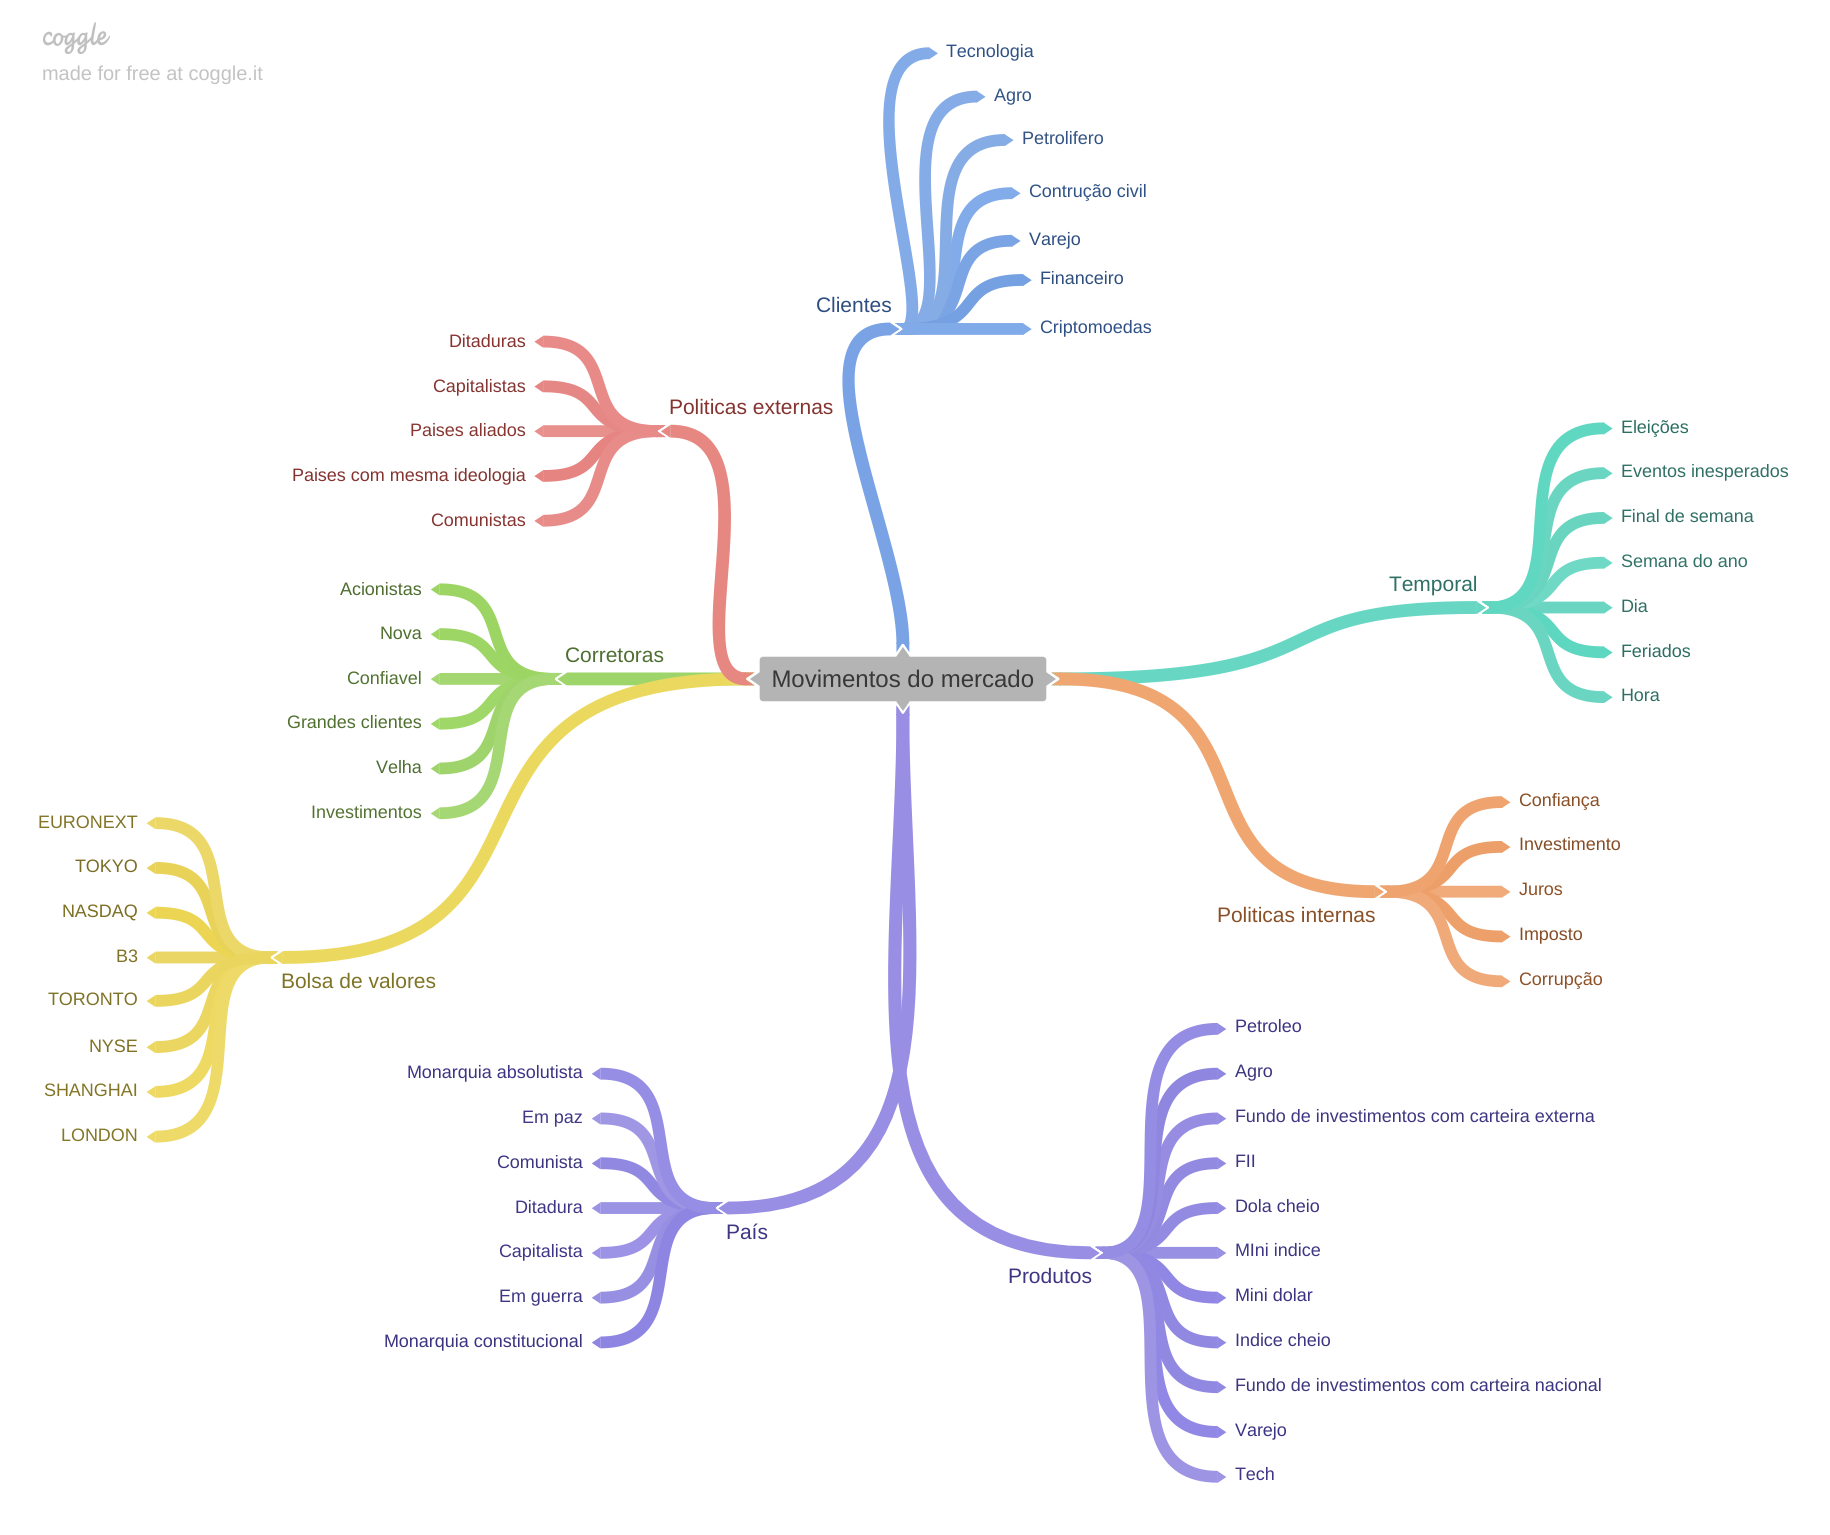

In [36]:
Image( 'img/mapa.png' )

### 3.2. Criação de hipoteses

#### 3.2.1. Clientes

1 - Maiores clientes tem capacidade de movimentar o mercado a seu favor

2 - Pessoas fisicas buscam maior segurança na hora de realizar investimentos

3 - Clientes de maior idade costumam investir em ativos imobiliarios com maior frequencia

4 - Clientes de menor idade preferem investimentos de alto risco

5 - Mulheres tem preferencia por realizar investimentos na area de varejo

6 - Homens tem preferencia por realizar investimentos na area de Agro

7 - O mercado de petrolio é o mais escolhido por clientes com CNPJ

8 - Clientes que fazem investimentos de risco baixo ao longo dos anos tem o dobro de lucro comparado aos que fazem de alto risco e tem menos de 24 anos

#### 3.2.2. Politicas externas

1 - Paises com politicas acordos bilaterais tem as bolsas com maior volume comparado aos demais

#### 3.2.3. Temporal

1 - Bolsas que não fecham aos finais de semana tem a maior quantidade de clientes

2 - Bolsas de horario aposto as duas maiores do mundo (EUA e Japão) tem maior volume transacionado no momento de fechamento x abertura 

3 - Criptomoedas tem maior rentabilidade maior com o passar dos anos comparado a ações comuns 

4 - Ano eleitoral no Brasil a bolsa tem uma forte queda nos preços

5 - No natal as movimentações são menores

6 - No inicio do ano os preços sobem e ao final tendem a diminuir

#### 3.2.4. Politicas internas

1 - Paises focados no desenvolvimento e com PIB em crescimento positivo sofrem menos com quedas na bolsa

2 - Paises que vem realizando uma policita de aumento de impostos tendem a ter menos clientes ativos na bolsa

3 - Paises que fazem incentivos aos estudos financeiros nas escolas tem o maior numero de clientes ativos no mercado financeiro

#### 3.2.5. Corretoras

1 - Corretoras com menores taxas tem maior quantidade de clientes em modo de churn

2 - Corretoras com maiores taxas de transações mas com o melhor suporte tem clientes com as maiores carteiras de investimentos

3 - Corretoras que oferecem plataformas de trading gratuitas conseguem mais clientes que se fidelizam ao longo do tempo

4 - A Binance teve o maior valor financeiro transacionado do que a XP, Modal e Rico juntas

#### 3.2.6. Bolsa de valores

1 - As bolsas dos EUA tem o maior volume transacionado do que a do Brasil, Argentia e Chile juntas

2  - A B3 tem atualmente o maior numero de investidores do Brasil de todos os anos 

3 - A abertura de fundos de investimentos comercializados na B3 vem em alta nos ultimos 3 anos

4 - NASDAQ e TOKYO tem quantidade de clientes parecidas

#### 3.2.7. Clientes

1 - Clientes que investem em papeis do seguimento de petroleo tem as menores perdas 

2 - Clientes que tem idade maior que 35 anos conseguem o dobro de rentabilidade que pessoas abaixo de 30

3 - Clientes que vivem no estado de São paulo preferem investimentos de risco controlado

4 - Clientes que  vivem no região Sul do Brasil iniciam na bolsa com mercade de indice futuro

5 - Clientes que tem a maior diverisificação de produtos são os que menos sofrem com as variações do mercado 

#### 3.2.8. País

1 - O Brasil é o país que vem com maior crescimento de investidores comparado aos outros emergentes

2 - Os papeis relacionados ao agro negocio no Brasil são as melhores escolhas ao longo dos anos

3 - IVVB11 tem a rentabilidade aumentada quando o Dolar aumenta em relação ao preço do Real

4 - BOVA11 teve forte queda no inicio da pandemia no Brasil

#### 3.2.9. Produtos

1 - O dolar tem o volume menor que o Bitcoin

2 - Se BOVA11 sobe de preço SMAL11 segue o crescimento de forma parecida

3 - No ultimo ano Bitcoin e Ethereum tiveram melhor rentabilidade comparada ao dolar

4 - BOVA11 tem seu preço derrubado em ano de eleição presidencial

5 - IVVB11 aumenta após fim das eleições norte americanas

### 3.3. Lista final de Hiposteses

1 - O dolar tem o volume menor que o Bitcoin

2 - Se BOVA11 sobe de preço SMAL11 segue o crescimento de forma parecida

3 - No ultimo ano Bitcoin e Ethereum tiveram melhor rentabilidade comparada ao dolar

4 - BOVA11 tem seu preço derrubado em ano de eleição presidencial

5 - IVVB11 aumenta após fim das eleições norte americanas

OBS: A a criação do mapa mental contendo o fenomeno que estamos tentando entender respectivamente com seus agentes que impactam nesse fenenome e seus atributos, tem como objetivo principal auxiliar na elaboração de uma diversificação maior e trazendo o Cientista de dados para dentro do contexto do negocio para assim conseguir propor as melhroes soluções com dados e tambem levantar a necessidade de se buscar datasets complementares para responder as questões que não foram para a Lista final de hipoteses no primeiro ciclo do CRISP-DS

### 3.1. Feature Creation

In [37]:
# Criar features do dia, semana do mes, mes e ano 
# facilita para encontrar eventos especificos que desencaderam determinados comportamentos nos dados, eleições, feriados, etc...

In [38]:
df3_dolar[['data']].head()

,data
0,2021-07-19
1,2021-07-18
2,2021-07-17
3,2021-07-16
4,2021-07-15


In [39]:
# Dolar
df3_dolar['dia'] = df3_dolar['data'].dt.day
df3_dolar['mes'] = df3_dolar['data'].dt.month
df3_dolar['semana_ano'] = df3_dolar['data'].dt.weekofyear
df3_dolar['ano'] = df3_dolar['data'].dt.year

# BOVA11
df3_bova11['dia'] = df3_bova11['data'].dt.day
df3_bova11['mes'] = df3_bova11['data'].dt.month
df3_bova11['semana_ano'] = df3_bova11['data'].dt.weekofyear
df3_bova11['ano'] = df3_bova11['data'].dt.year

# SMAL11
df3_smal11['dia'] = df3_smal11['data'].dt.day
df3_smal11['mes'] = df3_smal11['data'].dt.month
df3_smal11['semana_ano'] = df3_smal11['data'].dt.weekofyear
df3_smal11['ano'] = df3_smal11['data'].dt.year

# Bitcoin
df3_bitcoin['dia'] = df3_bitcoin['data'].dt.day
df3_bitcoin['mes'] = df3_bitcoin['data'].dt.month
df3_bitcoin['semana_ano'] = df3_bitcoin['data'].dt.weekofyear
df3_bitcoin['ano'] = df3_bitcoin['data'].dt.year

# Ethereum
df3_ethereum['dia'] = df3_ethereum['data'].dt.day
df3_ethereum['mes'] = df3_ethereum['data'].dt.month
df3_ethereum['semana_ano'] = df3_ethereum['data'].dt.weekofyear
df3_ethereum['ano'] = df3_ethereum['data'].dt.year


In [40]:
# Categorizar dados e concatenar dataframe

df3_dolar['papel'] = 'dolar' 
df3_bova11['papel'] = 'bova11'
df3_smal11['papel'] = 'smal11'
df3_bitcoin['papel'] = 'bitcoin'
df3_ethereum['papel'] = 'ethereum'

In [41]:
df3_dolar.sample()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,semana_ano,ano,papel
301,2020-09-27,5.5626,0.0,0.0002,5.56135,5.56135,5.56135,0,27,9,39,2020,dolar


In [42]:
# df3 = pd.DataFrame(df3_dolar, df3_bova11 columns = ['data', 'fechamento', 'variacao', 'retorno_mensal_perc', 'abertura', 'maxima', 'minima', 'volume', 'papel'])

df3 = pd.concat([df3_dolar, df3_bova11, df3_smal11, df3_bitcoin, df3_ethereum ])

df3

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,semana_ano,ano,papel
0,2021-07-19,5.25240,0.14,0.0268,5.11680,5.25820,5.11329,0,19,7,29,2021,dolar
1,2021-07-18,5.11550,0.00,0.0000,5.11571,5.11571,5.11550,0,18,7,28,2021,dolar
2,2021-07-17,5.11550,0.00,0.0000,5.11037,5.11550,5.11037,0,17,7,28,2021,dolar
3,2021-07-16,5.11545,0.00,0.0008,5.11180,5.12680,5.07570,0,16,7,28,2021,dolar
4,2021-07-15,5.11150,0.04,0.0079,5.07180,5.13850,5.05626,0,15,7,28,2021,dolar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2021-05-24,2636.70000,525.67,0.2490,2133.21000,2678.25000,2072.15000,1061703,24,5,21,2021,ethereum
2207,2021-05-23,2111.03000,-196.08,-0.0850,2272.03000,2382.00000,1728.00000,1172601,23,5,20,2021,ethereum
2208,2021-05-22,2307.11000,-76.08,-0.0319,2344.68000,2385.56000,2255.00000,292784,22,5,20,2021,ethereum
2209,2021-05-21,2383.19000,-373.20,-0.1354,2823.77000,2950.00000,2106.33000,1108166,21,5,20,2021,ethereum


**OBS: Para um proximo ciclo talvez seja interessante adicionar na coluna do dia atual, o fechamento do dia anterior, o fechamento do dia anterior influencia no preço do fechamento do dia**

## **4.0. Exploratory data analysis**

In [43]:
df4 = df3.copy()

In [44]:
df4.sample()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,semana_ano,ano,papel
2921,2013-09-22,2.2132,0.0,0.0016,2.2097,2.2132,2.2092,4,22,9,38,2013,dolar


### 4.1. Analise Univariada

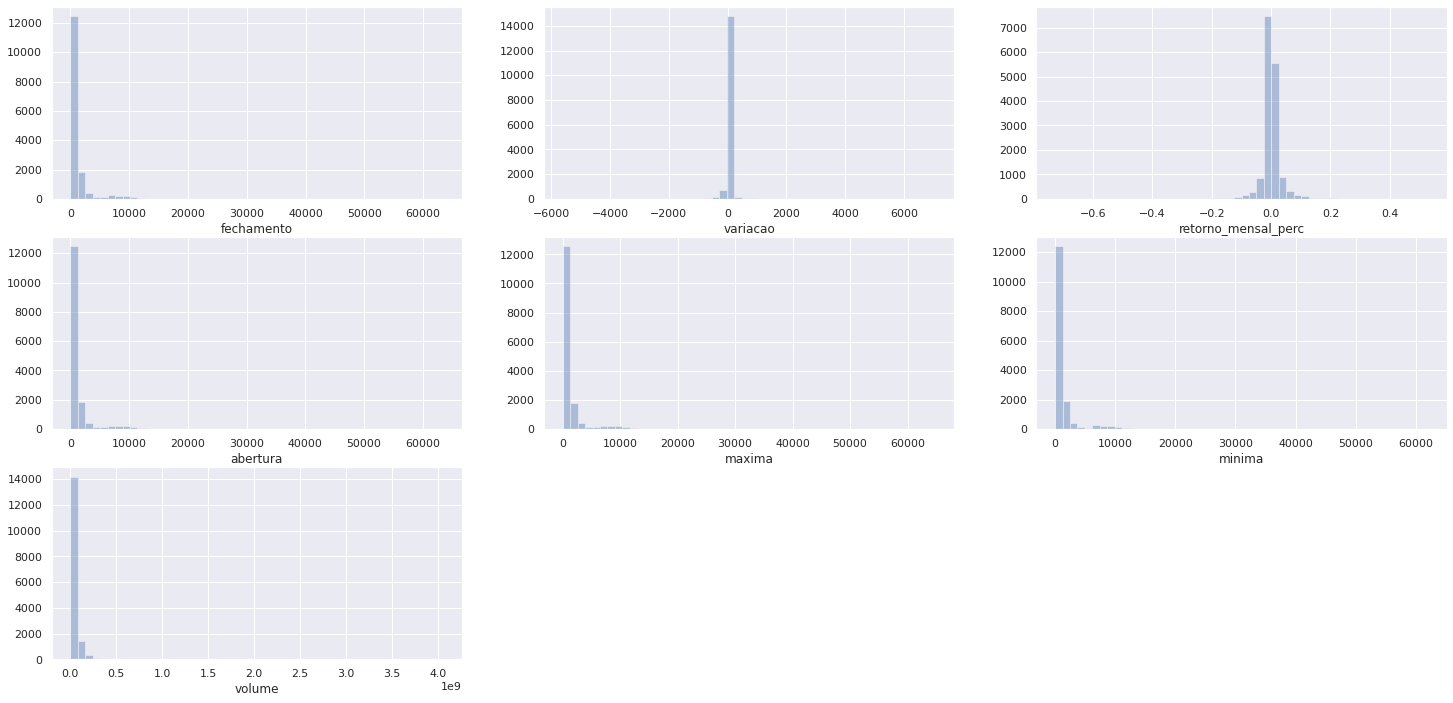

In [45]:
# fechamento
plt.subplot( 3, 3, 1 )
#plt.rcParams['figure.figsize'] = [12, 20]
#sns.set()
sns.distplot( df4['fechamento'], kde=False  );


# fechamento
plt.subplot( 3, 3, 2 )
#plt.rcParams['figure.figsize'] = [12, 10]
#sns.set()
sns.distplot( df4['variacao'], kde=False  );

# Retorno mensal em percentual 
plt.subplot( 3, 3, 3 )
sns.distplot( df4['retorno_mensal_perc'], kde=False  );

# Preço de abertura
plt.subplot( 3, 3, 4 )
sns.distplot( df4['abertura'], kde=False  );


# Preço da maxima
plt.subplot( 3, 3, 5 )
sns.distplot( df4['maxima'], kde=False  );


# Preço da minima
plt.subplot( 3, 3, 6 )
sns.distplot( df4['minima'], kde=False  );

# Volume total do dia
plt.subplot( 3, 3, 7 )
sns.distplot( df4['volume'], kde=False  );

##### 4.1.2. Variavel resposta

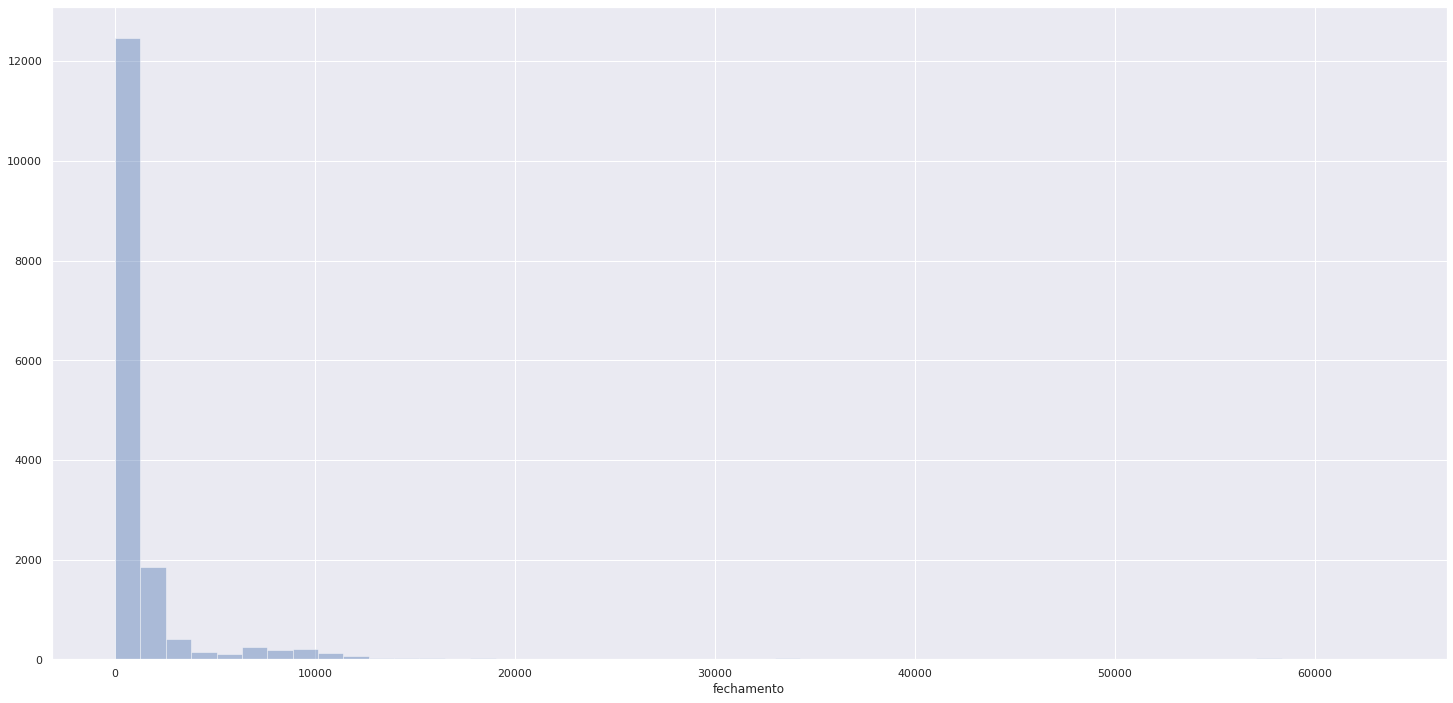

In [46]:
# fechamento
# Estou considerando o fechamento como variavel respota pois é com o fechamento que as corretoras atualizam os valores em carteira de seus clientes

sns.distplot( df4['fechamento'], kde=False  );

### 4.2. Variavel numerica

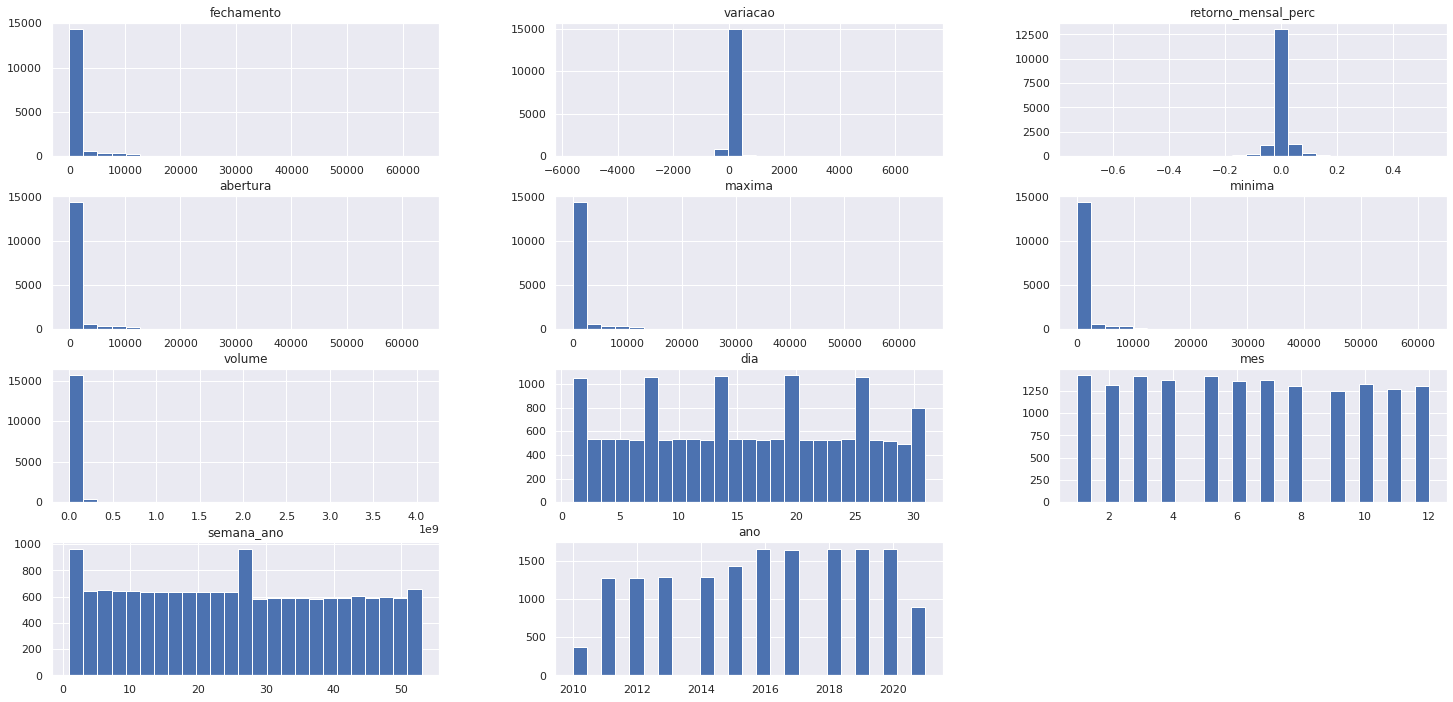

In [47]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=25 );

### 4.3. Variavel categorica

In [48]:
cat_attributes = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 4.3.1. Categorical atributes

In [49]:
# Neste caso o dataset simples e não precisaria de uma analise de quantos tipos de variaveis categoricas temos, está aqui so para 
# representação de conhecimento de como explorar melhor um volume maior de dados
# Neste caso temos apenas 5 tipos de categorias, que são: Dolar, BOVA11, SMAL11, Bitcoin e Ethereum
cat_attributes.apply( lambda x: x.unique().shape[0] )

papel    5
dtype: int64

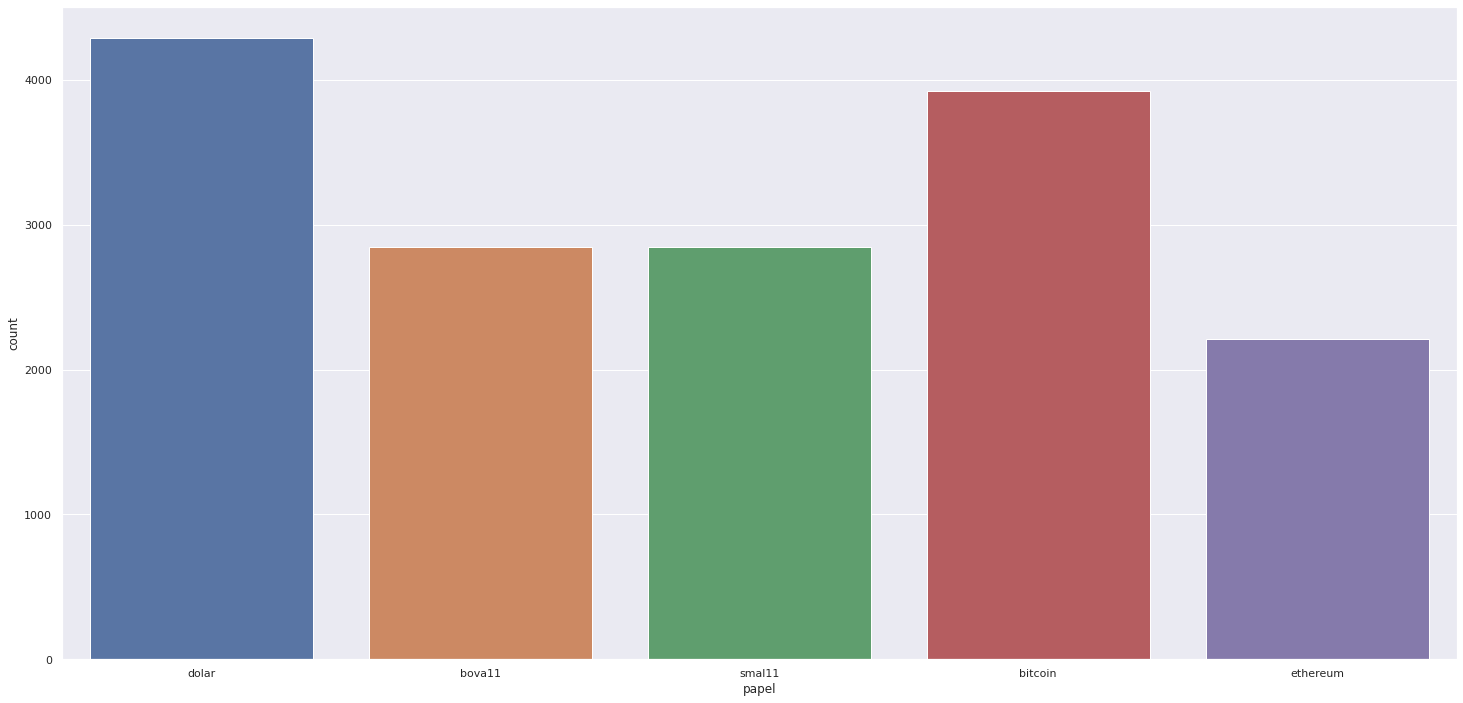

In [50]:
# Quantidade de dados que temos disponivel de cada papel
sns.countplot(df4['papel']);

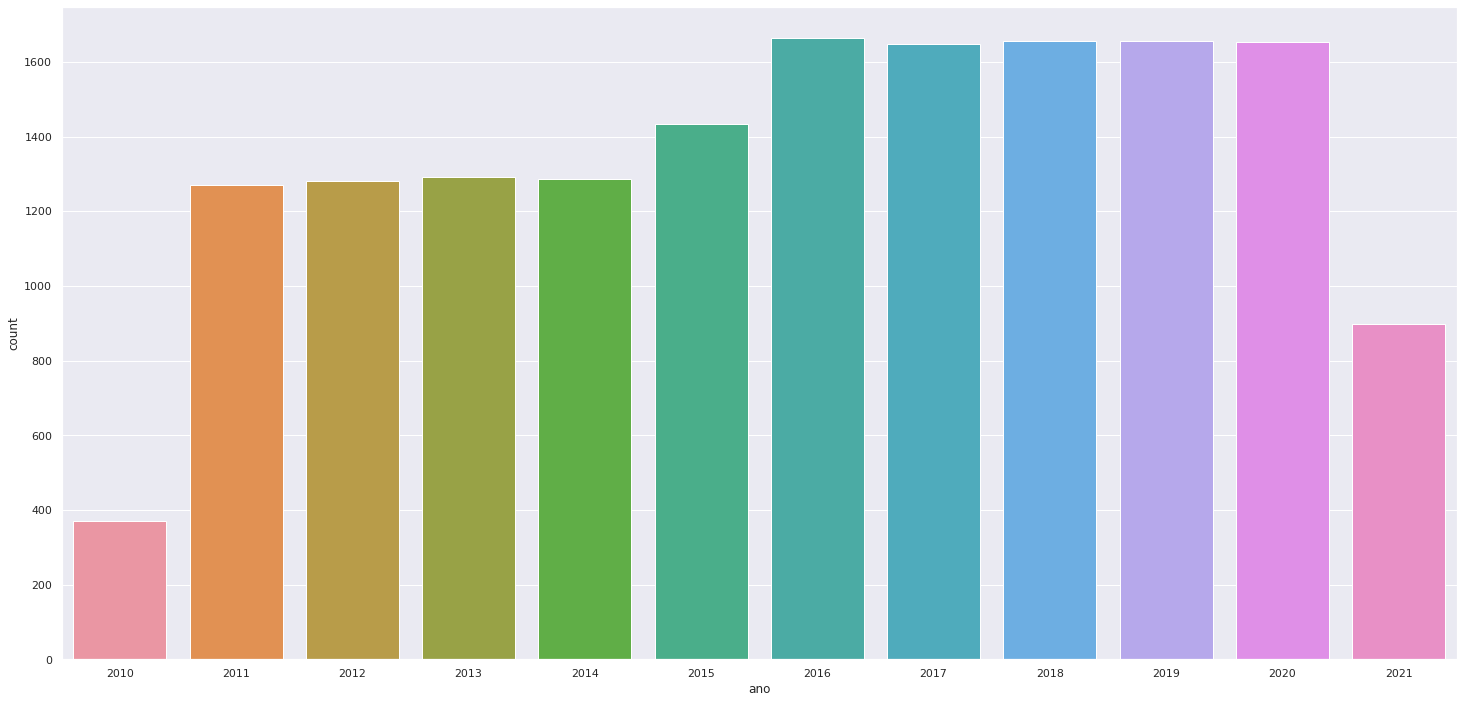

In [51]:
# Quantidade de dados que temos disponivel de cada papel
sns.countplot(df4['ano']);

### 4.4. Analise Bivariada

#### **1** - O dolar tem o volume menor que o Bitcoin

**FALSO**, o Bitcoin tem o volume transacionado proximo ao do dolar, existiu apenas uma explosão no volume em 2019 mas que vale uma analise mais aprofundado para entender esse fenomeno posteriormente


<AxesSubplot:xlabel='ano'>

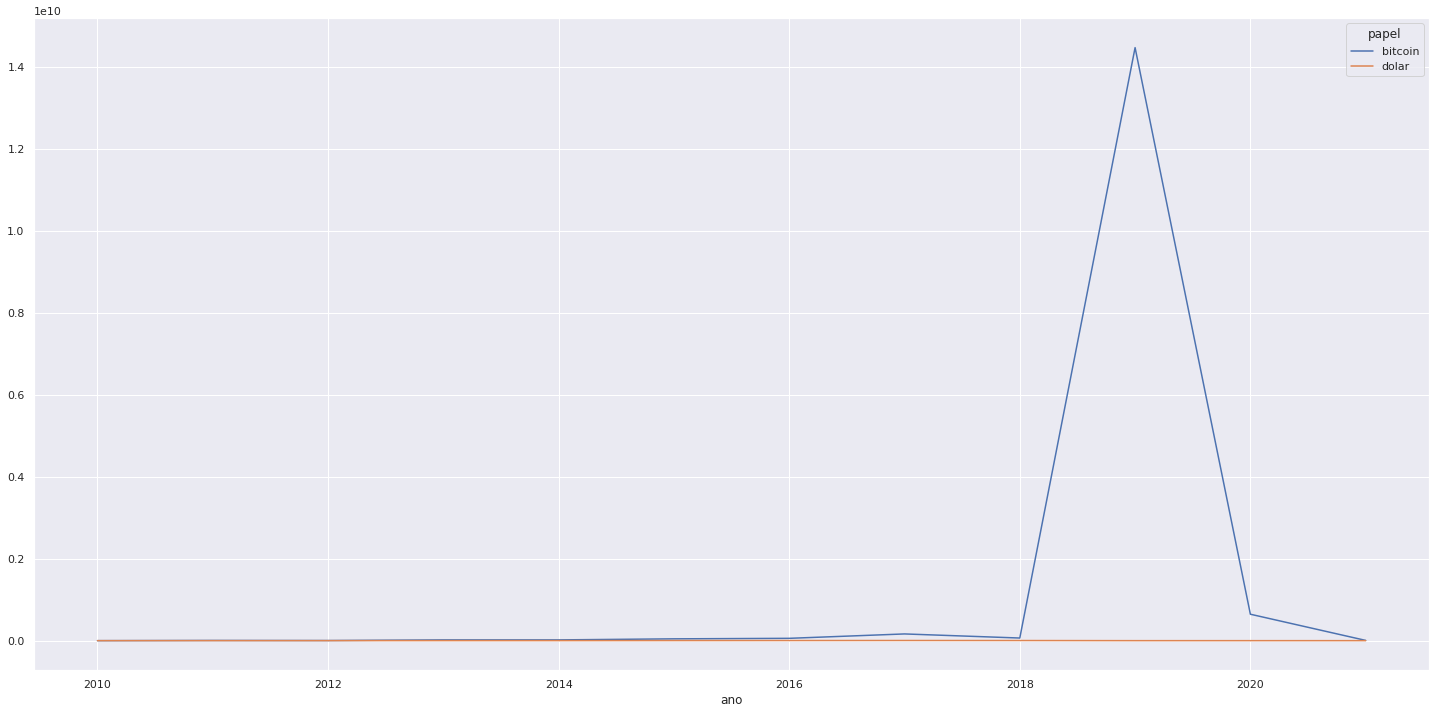

In [52]:
aux = df4[(df4['papel'] == 'dolar') | (df4['papel'] == 'bitcoin')]
aux1 = aux[['ano', 'papel', 'volume']].groupby(['ano', 'papel']).sum().reset_index()
aux1.pivot(index='ano', columns='papel', values='volume').plot()

#### **2** - Se BOVA11 sobe de preço SMAL11 segue o crescimento de forma parecida
**FALSO**, não tem qualquer relação os movimentos no fechamento

<AxesSubplot:xlabel='ano'>

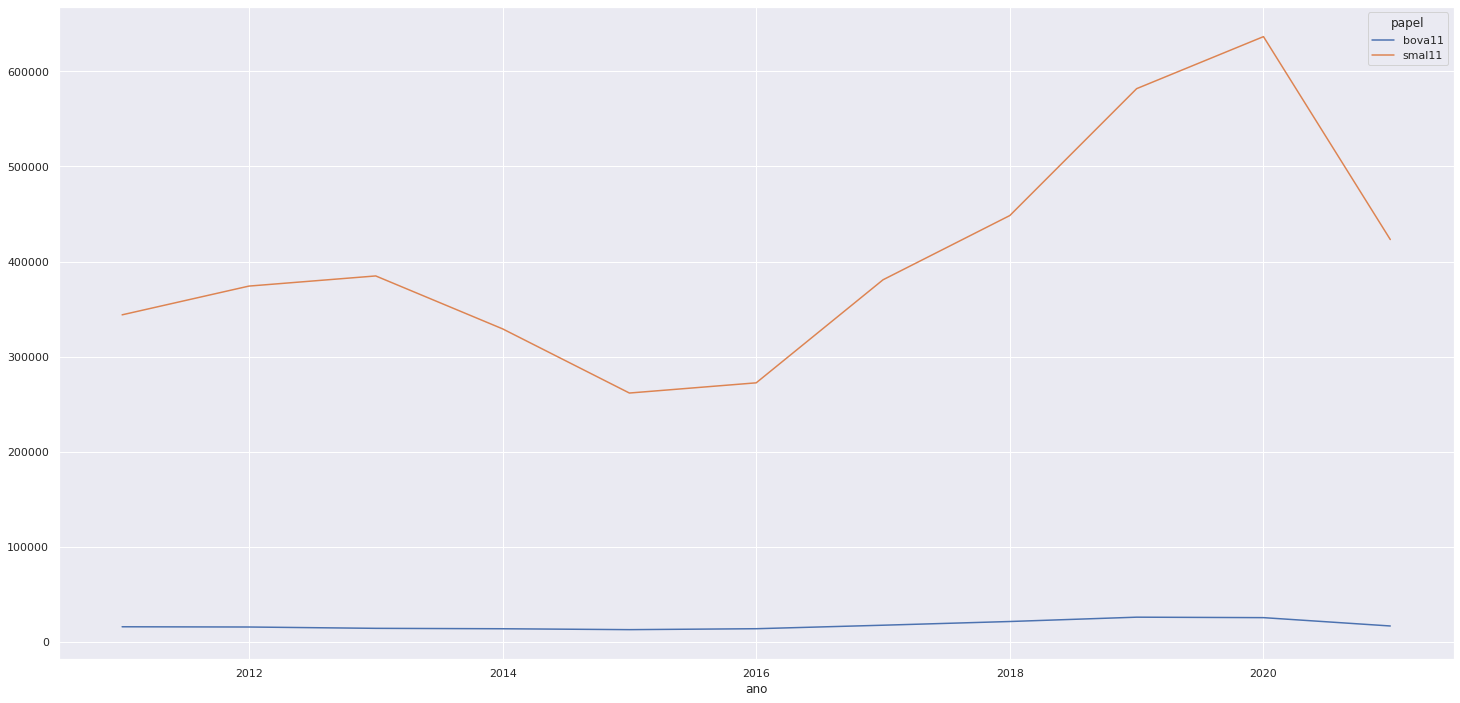

In [53]:
aux = df4[(df4['papel'] == 'bova11') | (df4['papel'] == 'smal11')]
aux1 = aux[['ano', 'papel', 'fechamento']].groupby(['ano', 'papel']).sum().reset_index()
aux1.pivot(index='ano', columns='papel', values='fechamento').plot()


## Fazer no segundo ciclo uma matriz de correlação entre os 2

#### **3** - No ultimo ano Bitcoin e Ethereum tiveram melhor rentabilidade comparada ao dolar
**VERDADEIRO**, o valor de fechamento do dolar se tornou irrelevante comparado ao Bitcoin e Ethereum

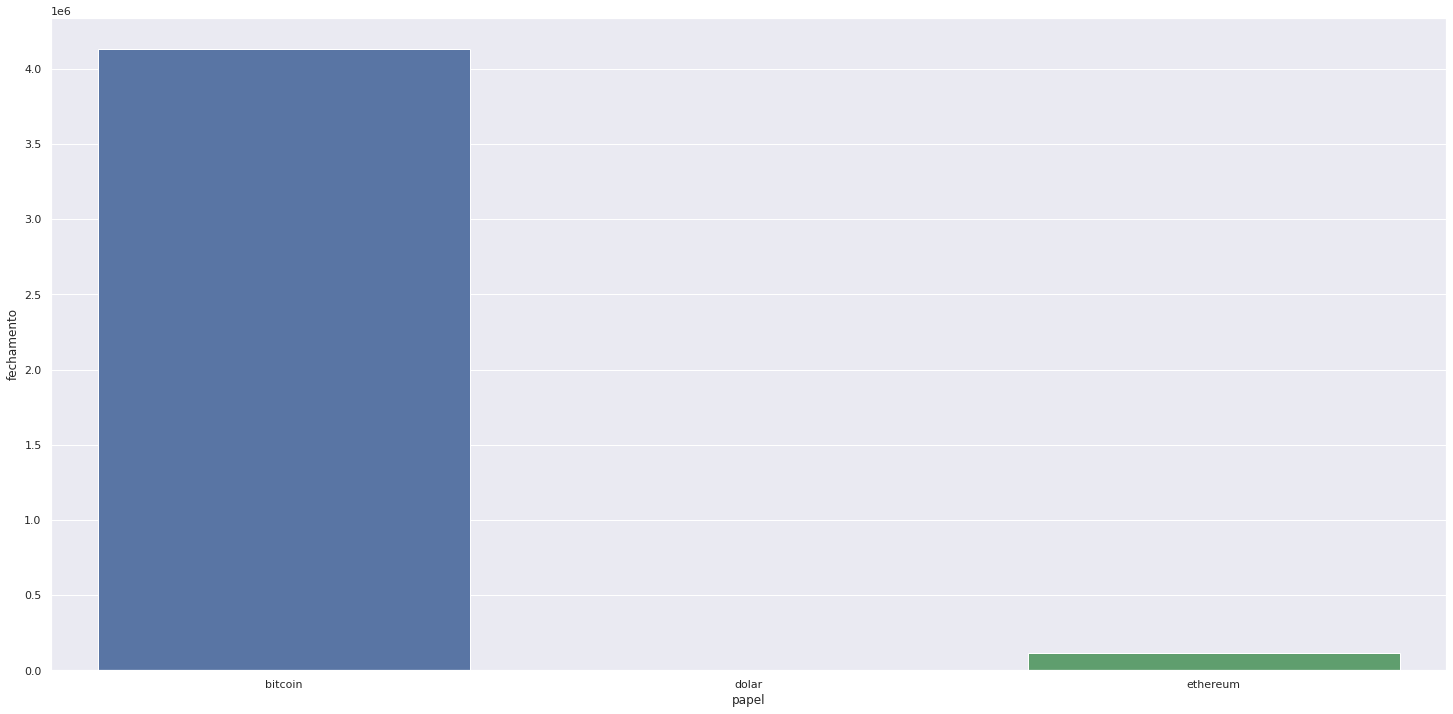

In [54]:
# Estou usando o ano de 2020 como base para ultimo ano pois em 2021 os dados não estão completos
# Vou verificar também como  foi o ano de 2019 pois devido a pandemia em 2020 podem ter existido fatores fora da normalidade/naturalidade ainda 
# que não seja um outlier pois é algo que realmente ocorreu

aux = df4[df4['ano'] == 2020]
aux2 = aux[(aux['papel'] == 'bitcoin') | (aux['papel'] == 'ethereum') | (aux['papel'] == 'dolar')]
aux3 = aux2[['ano', 'papel', 'fechamento']].groupby(['ano', 'papel']).sum().reset_index()
sns.barplot(x='papel', y='fechamento', data=aux3);

#### 4 - BOVA11 tem seu preço derrubado em ano de eleição presidencial

**DADOS insuficientes**, segundo os dados que temos, podemos considerar as eleições de:

2010 = Observace um movimento que veio caindo 

2014 = Segue em queda após a continuação do trabalho presidencial

2018 = Em 31/08/2016 ouve o impeachment da presidente e então os preços decolaram e a queda em 2020 se da por conta da pandemia da Covid

**OBS:** 12 eleições presidenciais já foram realizadas no Brasil desde 1945


<AxesSubplot:xlabel='ano'>

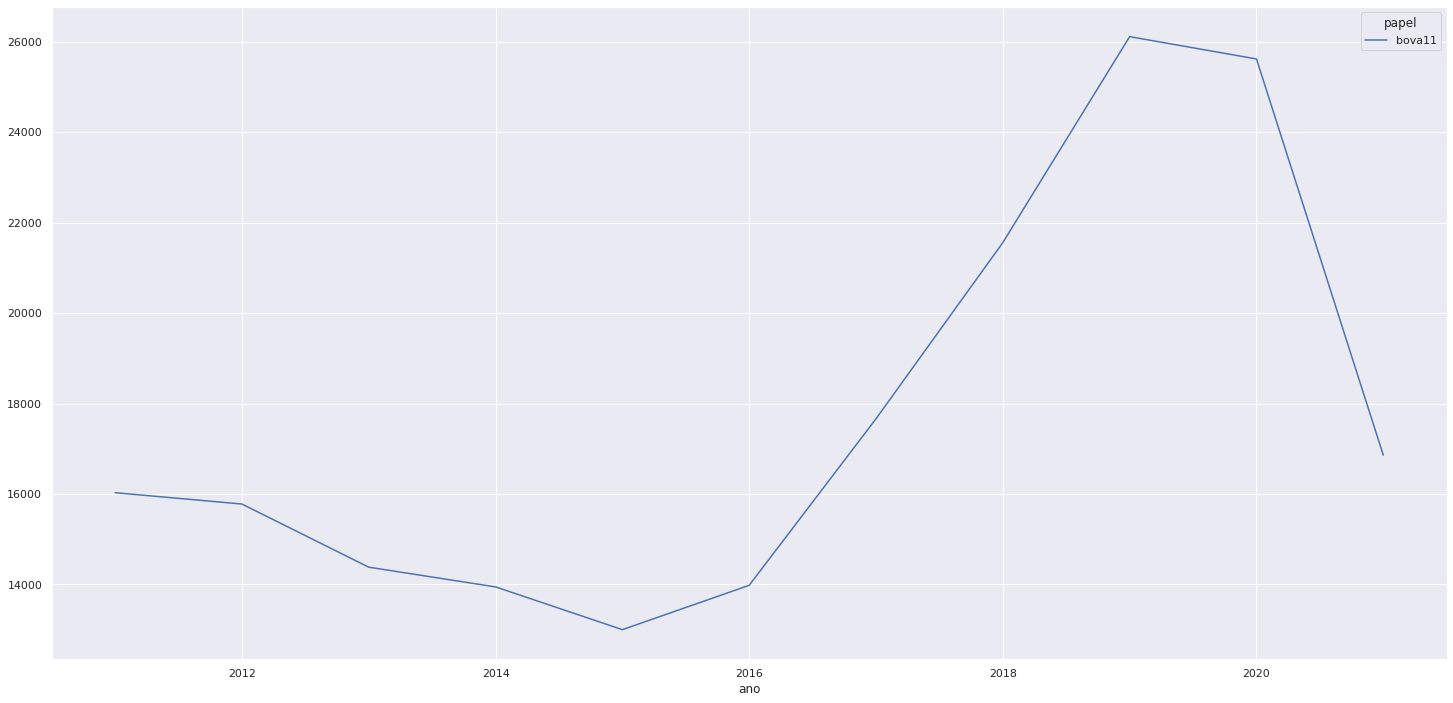

In [55]:
aux = df4[df4['papel'] == 'bova11']
aux1 = aux[['ano', 'papel', 'fechamento']].groupby(['ano', 'papel']).sum().reset_index()
aux1.pivot(index='ano', columns='papel', values='fechamento').plot()

5 - SMAL11 aumenta após fim das eleições norte americanas.

**DADOS INSUFICIENTES**, tivemos 46 eleições mas temos somente dados para 4 eleições.]

Um movimento que deve ser aprofundado é o movimento de alta em 2016 com a entrada de Trump na disputa.

A queda em 2020 se da pelo inicio da pandemia da covid 19 

2008 a 2016 = Obama 

2017 a 2020 = Trump

2021 = Biden

Podemos considerar com os dados disponiveis apartir do ano de 2010

**OBS:** EUA já tiveram 46 presidentes considerando a atual gestão de Biden

<AxesSubplot:xlabel='ano'>

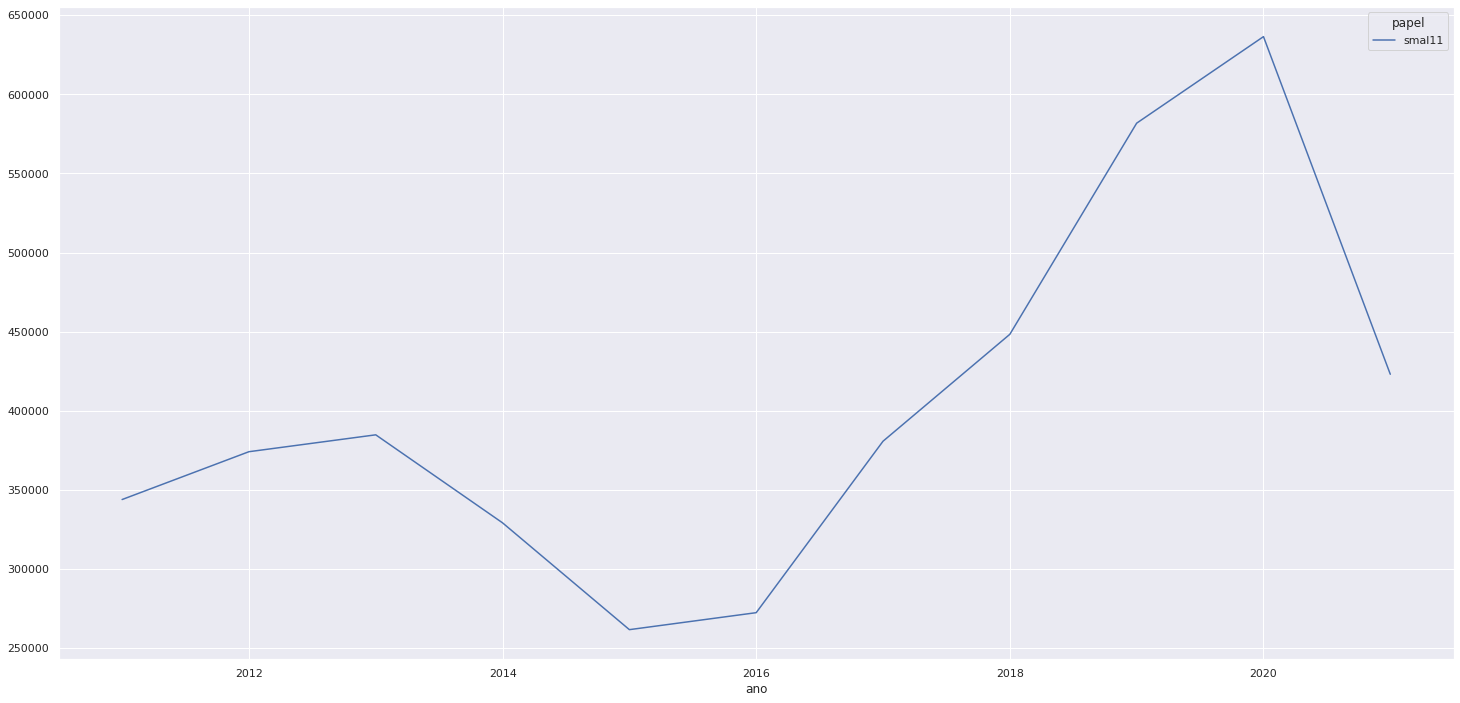

In [56]:
aux = df4[df4['papel'] == 'smal11']
aux1 = aux[['ano', 'papel', 'fechamento']].groupby(['ano', 'papel']).sum().reset_index()
aux1.pivot(index='ano', columns='papel', values='fechamento').plot()

### 4.4.   Resumo das hipoteses

In [57]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['1', 'Falsa', 'Baixa'],  
      ['2', 'Falsa', 'Media'],  
      ['3', 'Verdadeiro', 'Alta'],
      ['4', 'Dados insuficientes', 'Alta'],
      ['5', 'Dados insuficientes', 'Alta'],
      
     ]  
print( tabulate( tab, headers='firstrow' ) )

  Hipoteses  Conclusao            Relevancia
-----------  -------------------  ------------
          1  Falsa                Baixa
          2  Falsa                Media
          3  Verdadeiro           Alta
          4  Dados insuficientes  Alta
          5  Dados insuficientes  Alta


### 4.5. Analise Multivariada

#### 4.5.1. Numerical Attributes

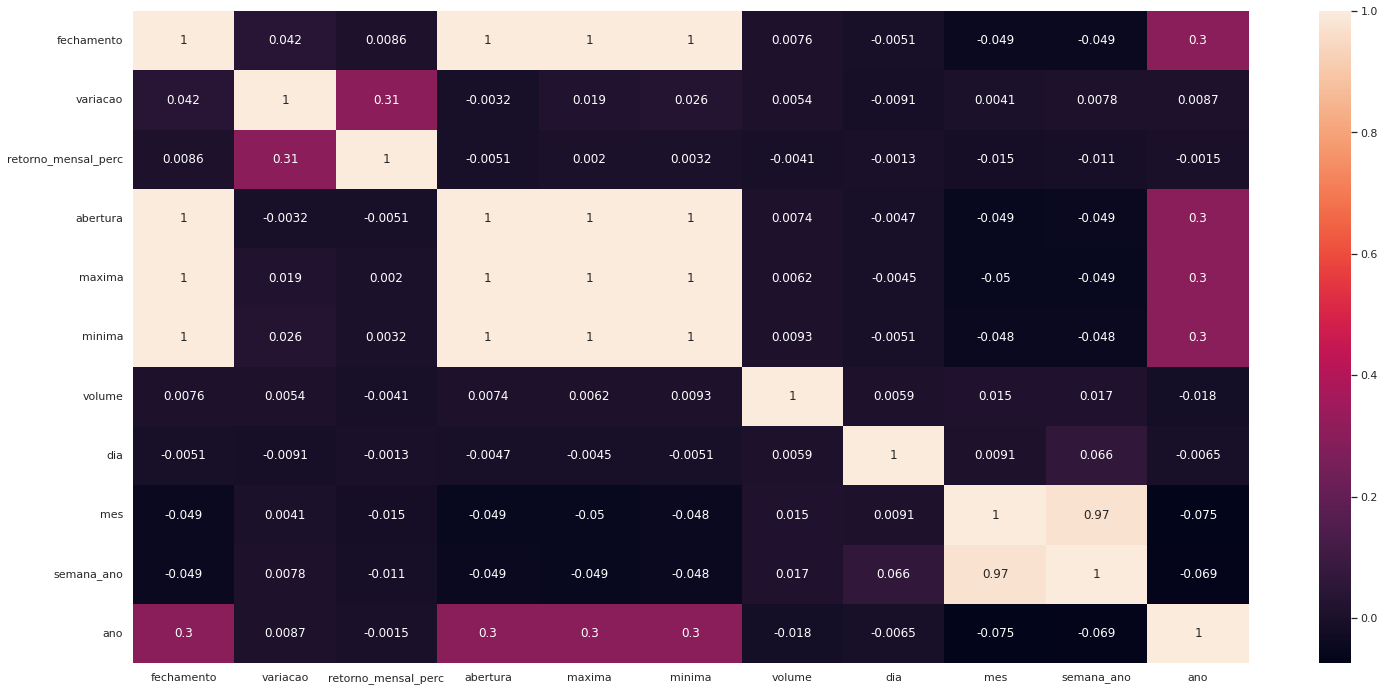

In [58]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

## **5.0. Data preparation**

In [157]:
df5 = df4.copy()

### 5.1. Normalizacao

### 5.2. Rescaling

### 5.3. Encoding

In [158]:
# One Hot Encoding
#df5 = pd.get_dummies( df5, prefix=['papel'], columns=['papel'] )

# Label Encoding
le = LabelEncoder()
df5['papel'] = le.fit_transform( df5['papel'] )


df5

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,semana_ano,ano,papel
0,2021-07-19,5.25240,0.14,0.0268,5.11680,5.25820,5.11329,0,19,7,29,2021,2
1,2021-07-18,5.11550,0.00,0.0000,5.11571,5.11571,5.11550,0,18,7,28,2021,2
2,2021-07-17,5.11550,0.00,0.0000,5.11037,5.11550,5.11037,0,17,7,28,2021,2
3,2021-07-16,5.11545,0.00,0.0008,5.11180,5.12680,5.07570,0,16,7,28,2021,2
4,2021-07-15,5.11150,0.04,0.0079,5.07180,5.13850,5.05626,0,15,7,28,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2021-05-24,2636.70000,525.67,0.2490,2133.21000,2678.25000,2072.15000,1061703,24,5,21,2021,3
2207,2021-05-23,2111.03000,-196.08,-0.0850,2272.03000,2382.00000,1728.00000,1172601,23,5,20,2021,3
2208,2021-05-22,2307.11000,-76.08,-0.0319,2344.68000,2385.56000,2255.00000,292784,22,5,20,2021,3
2209,2021-05-21,2383.19000,-373.20,-0.1354,2823.77000,2950.00000,2106.33000,1108166,21,5,20,2021,3


### 5.4. Nature transformation

In [159]:
# dia sen e cos 
df5['dia_sen'] = df5['dia'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['dia_cos'] = df5['dia'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# mes sen e cos
df5['mes_sen'] = df5['mes'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['mes_cos'] = df5['mes'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


# semana do ano  sen e cos
df5['semana_ano_sen'] = df5['semana_ano'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['semana_ano_cos'] = df5['semana_ano'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# ano sen e cos
df5['ano_sen'] = df5['ano'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['ano_cos'] = df5['ano'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [160]:
df5.head()

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,...,ano,papel,dia_sen,dia_cos,mes_sen,mes_cos,semana_ano_sen,semana_ano_cos,ano_sen,ano_cos
0,2021-07-19,5.25240,0.14,0.0268,5.11680,5.25820,5.11329,0,19,7,...,2021,2,-7.431448e-01,-0.669131,-0.5,-0.866025,-0.354605,-0.935016,-0.748511,0.663123
1,2021-07-18,5.11550,0.00,0.0000,5.11571,5.11571,5.11550,0,18,7,...,2021,2,-5.877853e-01,-0.809017,-0.5,-0.866025,-0.239316,-0.970942,-0.748511,0.663123
2,2021-07-17,5.11550,0.00,0.0000,5.11037,5.11550,5.11037,0,17,7,...,2021,2,-4.067366e-01,-0.913545,-0.5,-0.866025,-0.239316,-0.970942,-0.748511,0.663123
3,2021-07-16,5.11545,0.00,0.0008,5.11180,5.12680,5.07570,0,16,7,...,2021,2,-2.079117e-01,-0.978148,-0.5,-0.866025,-0.239316,-0.970942,-0.748511,0.663123
4,2021-07-15,5.11150,0.04,0.0079,5.07180,5.13850,5.05626,0,15,7,...,2021,2,1.224647e-16,-1.000000,-0.5,-0.866025,-0.239316,-0.970942,-0.748511,0.663123


## **6.0. Feature selection**

In [161]:
df6 = df5.copy()

### 6.1. Dividir em treino e teste

In [162]:
# Verificado na EDA que 2016 a 2020 são os dados mais balanceados entre os 5 tipos que contem no dataset, então dessa forma estarei descartando para o primeiro ciclo os demais dados.
# Para os demais cicloes deverão ser recuperados esses dados
df6 = df6[(df6['ano'] >= 2016 ) & (df6['ano'] <= 2020)]
df6

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,dia,mes,...,ano,papel,dia_sen,dia_cos,mes_sen,mes_cos,semana_ano_sen,semana_ano_cos,ano_sen,ano_cos
205,2020-12-31,5.19360,0.00,-0.0001,5.19383,5.19483,5.18350,0,31,12,...,2020,2,2.079117e-01,0.978148,-2.449294e-16,1.000000,1.205367e-01,0.992709,-0.822984,0.568065
206,2020-12-30,5.19409,-0.02,-0.0031,5.21010,5.23489,5.15356,0,30,12,...,2020,2,-2.449294e-16,1.000000,-2.449294e-16,1.000000,1.205367e-01,0.992709,-0.822984,0.568065
207,2020-12-29,5.21010,-0.04,-0.0071,5.24709,5.24790,5.16580,0,29,12,...,2020,2,-2.079117e-01,0.978148,-2.449294e-16,1.000000,1.205367e-01,0.992709,-0.822984,0.568065
208,2020-12-28,5.24740,0.03,0.0059,5.21090,5.31210,5.16503,0,28,12,...,2020,2,-4.067366e-01,0.913545,-2.449294e-16,1.000000,1.205367e-01,0.992709,-0.822984,0.568065
209,2020-12-27,5.21680,0.00,0.0000,5.21680,5.21680,5.21680,0,27,12,...,2020,2,-5.877853e-01,0.809017,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.822984,0.568065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,2020-11-24,604.38000,-3.28,-0.0054,608.27000,623.47000,587.25000,600754,24,11,...,2020,3,-9.510565e-01,0.309017,-5.000000e-01,0.866025,-4.647232e-01,0.885456,-0.822984,0.568065
2024,2020-11-23,607.66000,43.97,0.0780,561.49000,611.43000,550.00000,641333,23,11,...,2020,3,-9.945219e-01,0.104528,-5.000000e-01,0.866025,-4.647232e-01,0.885456,-0.822984,0.568065
2025,2020-11-22,563.69000,13.52,0.0246,552.62000,581.80000,502.82000,552100,22,11,...,2020,3,-9.945219e-01,-0.104528,-5.000000e-01,0.866025,-5.680647e-01,0.822984,-0.822984,0.568065
2026,2020-11-21,550.17000,40.72,0.0799,510.55000,552.37000,471.07000,400071,21,11,...,2020,3,-9.510565e-01,-0.309017,-5.000000e-01,0.866025,-5.680647e-01,0.822984,-0.822984,0.568065


In [163]:
data_aux = df6['data'].min()
data_aux1 = df6['data'].max()
print('Data minima: {}'.format(data_aux))
print('Data Maxima: {}'.format(data_aux1))

Data minima: 2016-01-01 00:00:00
Data Maxima: 2020-12-31 00:00:00


In [164]:
# Excluir variveis que sofreram uma reescala pois algoritimos de regressão funcional melhor com valores na mesma escala
cols_drop = ['dia', 'mes', 'semana_ano', 'ano']
df6 = df6.drop(cols_drop, axis=1)

In [165]:
# training dataset
X_train = df6[df6['data'] < '2020-10-01']
y_train = X_train['fechamento']

# test dataset
X_test = df6[df6['data'] >= '2020-10-01']
y_test = X_test['fechamento']

print( 'Training Min Date: {}'.format(X_train['data'].min()))
print( 'Training Max Date: {}'.format(X_train['data'].max()))

print( '\nTest Min Date: {}'.format(X_test['data'].min()))
print( 'Test Max Date: {}'.format(X_test['data'].max()))


Training Min Date: 2016-01-01 00:00:00
Training Max Date: 2020-09-30 00:00:00

Test Min Date: 2020-10-01 00:00:00
Test Max Date: 2020-12-31 00:00:00


In [166]:
X_train

,data,fechamento,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,papel,dia_sen,dia_cos,mes_sen,mes_cos,semana_ano_sen,semana_ano_cos,ano_sen,ano_cos
298,2020-09-30,5.60990,-0.02,-0.0039,5.63242,5.63200,5.63200,0,2,-2.449294e-16,1.000000,-1.0,-1.836970e-16,-0.992709,1.205367e-01,-0.822984,0.568065
299,2020-09-29,5.63200,-0.03,-0.0052,5.66183,5.66130,5.66130,0,2,-2.079117e-01,0.978148,-1.0,-1.836970e-16,-0.992709,1.205367e-01,-0.822984,0.568065
300,2020-09-28,5.66170,0.10,0.0178,5.56005,5.56060,5.56060,0,2,-4.067366e-01,0.913545,-1.0,-1.836970e-16,-0.992709,1.205367e-01,-0.822984,0.568065
301,2020-09-27,5.56260,0.00,0.0002,5.56135,5.56135,5.56135,0,2,-5.877853e-01,0.809017,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065
302,2020-09-26,5.56135,0.00,0.0000,5.56135,5.56135,5.56135,0,2,-7.431448e-01,0.669131,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2020-09-25,351.59000,2.91,0.0083,349.73000,358.12000,337.59000,277027,3,-8.660254e-01,0.500000,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065
1963,2020-09-24,348.68000,11.06,0.0328,324.11000,353.14000,319.67000,429748,3,-9.510565e-01,0.309017,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065
1964,2020-09-23,337.62000,-5.95,-0.0173,343.97000,344.64000,332.51000,137357,3,-9.945219e-01,0.104528,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065
1965,2020-09-22,343.57000,1.34,0.0039,340.38000,376.76000,331.00000,190055,3,-9.945219e-01,-0.104528,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.822984,0.568065


### 6.2. Boruta feature selection

In [167]:
## training and test dataset for Boruta
X_train_n = X_train.drop( ['data', 'fechamento'], axis=1 ).values
y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	8
Iteration:

### 6.3. Best Features from Boruta 

In [169]:
cols_selected = boruta.support_.tolist()
#
## best features
X_train_fs = X_train.drop( ['data', 'fechamento'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [170]:
cols_selected_boruta

['variacao', 'retorno_mensal_perc', 'abertura', 'maxima', 'minima', 'volume']

In [171]:
cols_not_selected_boruta

['ano_cos',
 'ano_sen',
 'dia_cos',
 'dia_sen',
 'mes_cos',
 'mes_sen',
 'papel',
 'semana_ano_cos',
 'semana_ano_sen']

### 6.3. Manual Feature Selection

In [172]:
cols_selected_boruta_and_manual = [
    'variacao',
    'retorno_mensal_perc',
    'abertura',
    'maxima',
    'minima',
    'volume',
    'ano_cos',
    'ano_sen',
    'dia_cos',
    'dia_sen',
    'mes_cos',
    'mes_sen',
    'papel',
    'semana_ano_cos',
    'semana_ano_sen'
     ]


# columns to add
feat_to_add = ['data', 'fechamento']

cols_selected_boruta_full = cols_selected_boruta_and_manual.copy()
cols_selected_boruta_full.extend( feat_to_add )


## **7.0. Machine learning modelling**

In [173]:
x_train = X_train[ cols_selected_boruta_and_manual ]
x_test = X_test[ cols_selected_boruta_and_manual ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [174]:
x_training

,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,ano_cos,ano_sen,dia_cos,dia_sen,mes_cos,mes_sen,papel,semana_ano_cos,semana_ano_sen,data,fechamento
298,-0.02,-0.0039,5.63242,5.63200,5.63200,0,0.568065,-0.822984,1.000000,-2.449294e-16,-1.836970e-16,-1.0,2,1.205367e-01,-0.992709,2020-09-30,5.60990
299,-0.03,-0.0052,5.66183,5.66130,5.66130,0,0.568065,-0.822984,0.978148,-2.079117e-01,-1.836970e-16,-1.0,2,1.205367e-01,-0.992709,2020-09-29,5.63200
300,0.10,0.0178,5.56005,5.56060,5.56060,0,0.568065,-0.822984,0.913545,-4.067366e-01,-1.836970e-16,-1.0,2,1.205367e-01,-0.992709,2020-09-28,5.66170
301,0.00,0.0002,5.56135,5.56135,5.56135,0,0.568065,-0.822984,0.809017,-5.877853e-01,-1.836970e-16,-1.0,2,-1.836970e-16,-1.000000,2020-09-27,5.56260
302,0.00,0.0000,5.56135,5.56135,5.56135,0,0.568065,-0.822984,0.669131,-7.431448e-01,-1.836970e-16,-1.0,2,-1.836970e-16,-1.000000,2020-09-26,5.56135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2.91,0.0083,349.73000,358.12000,337.59000,277027,0.568065,-0.822984,0.500000,-8.660254e-01,-1.836970e-16,-1.0,3,-1.836970e-16,-1.000000,2020-09-25,351.59000
1963,11.06,0.0328,324.11000,353.14000,319.67000,429748,0.568065,-0.822984,0.309017,-9.510565e-01,-1.836970e-16,-1.0,3,-1.836970e-16,-1.000000,2020-09-24,348.68000
1964,-5.95,-0.0173,343.97000,344.64000,332.51000,137357,0.568065,-0.822984,0.104528,-9.945219e-01,-1.836970e-16,-1.0,3,-1.836970e-16,-1.000000,2020-09-23,337.62000
1965,1.34,0.0039,340.38000,376.76000,331.00000,190055,0.568065,-0.822984,-0.104528,-9.945219e-01,-1.836970e-16,-1.0,3,-1.836970e-16,-1.000000,2020-09-22,343.57000


### 7.1. Average Model

In [175]:
x_test.head()

,variacao,retorno_mensal_perc,abertura,maxima,minima,volume,ano_cos,ano_sen,dia_cos,dia_sen,mes_cos,mes_sen,papel,semana_ano_cos,semana_ano_sen
205,0.00,-0.0001,5.19383,5.19483,5.18350,0,0.568065,-0.822984,0.978148,2.079117e-01,1.0,-2.449294e-16,2,0.992709,1.205367e-01
206,-0.02,-0.0031,5.21010,5.23489,5.15356,0,0.568065,-0.822984,1.000000,-2.449294e-16,1.0,-2.449294e-16,2,0.992709,1.205367e-01
207,-0.04,-0.0071,5.24709,5.24790,5.16580,0,0.568065,-0.822984,0.978148,-2.079117e-01,1.0,-2.449294e-16,2,0.992709,1.205367e-01
208,0.03,0.0059,5.21090,5.31210,5.16503,0,0.568065,-0.822984,0.913545,-4.067366e-01,1.0,-2.449294e-16,2,0.992709,1.205367e-01
209,0.00,0.0000,5.21680,5.21680,5.21680,0,0.568065,-0.822984,0.809017,-5.877853e-01,1.0,-2.449294e-16,2,1.000000,-2.449294e-16


In [177]:
aux1 = x_test.copy()
aux1['fechamento'] = y_test.copy()

# prediction
aux2 = aux1[['papel', 'fechamento']].groupby( 'papel' ).mean().reset_index().rename( columns={'fechamento': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='papel' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,915.540102,504.134254,2233.973296


### 7.2. Linear Regression Model

In [178]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,11.356626,0.044155,32.317681


#### 7.2.1 Cross validation

In [191]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,8.65 +/- 2.24,0.09 +/- 0.03,26.14 +/- 10.86


### 7.3. Random Forest Regressor

In [144]:
y_train.isna().sum()

0

In [179]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,281.947435,0.018996,1250.00358


#### 7.3.1. Cross Validation

In [193]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,30.75 +/- 14.37,0.01 +/- 0.01,91.79 +/- 61.49


### 7.5. XGBoost Regressor

In [180]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, yhat_xgb)
xgb_result

[14:38:20] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1965.90585,0.378839,4156.489581


#### 7.5.1 Cross validation

In [194]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5
[14:46:48] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[14:46:49] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 3
[14:46:50] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passe

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,926.86 +/- 157.18,0.36 +/- 0.0,1670.32 +/- 278.94


### 7.6. Compare Model's Performance

In [183]:
modelling_result = pd.concat( [baseline_result, lr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,11.356626,0.044155,32.317681
0,Random Forest Regressor,281.947435,0.018996,1250.003580
0,Average Model,915.540102,504.134254,2233.973296
0,XGBoost Regressor,1965.905850,0.378839,4156.489581


#### 7.6.1 Cross Validation

In [197]:
modelling_result_cv = pd.concat( [lr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,8.65 +/- 2.24,0.09 +/- 0.03,26.14 +/- 10.86
0,Random Forest Regressor,30.75 +/- 14.37,0.01 +/- 0.01,91.79 +/- 61.49
0,XGBoost Regressor,926.86 +/- 157.18,0.36 +/- 0.0,1670.32 +/- 278.94


## 8.0. Hyperparameter fine tuning

In [199]:
### 8.1. Ramdon Search